# Notebook exploration données : event les plus fréquents

## Imports

### Librairies

In [2]:
import os, json, ast
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from babel.dates import format_date
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import LabelEncoder


from pprint import pprint

### Data

In [5]:
# nom de fichier et chemin relatif
filename = 'merge_raw_metrics_dataset.csv'
path = '../data/metrics/'
# création d'un dataframe à partir du csv de données
metrics_df = pd.read_csv(path+filename, index_col=0).sort_values(by='created_at')
metrics_df.head(2)

FileNotFoundError: [Errno 2] No such file or directory: '../data/metrics/img/merge_raw_metrics_dataset.csv'

In [ ]:
metrics_df.columns

Index(['id', 'status', 'created_at', 'varnishLevelsTargetvolume',
       'varnishLevelsTotalvolume', 'events', 'operators_name',
       'operators_level', 'VarnishPrinter_3DVarnishCounter',
       'iFoil_TotalPagesCounter', 'events_id'],
      dtype='object')

## Nettoyage

In [ ]:
# indexation du dataset avec les valeurs "created_at"
# metrics_df.index = metrics_df['created_at']
# indexation du dataset avec les valeurs "id"
# metrics_df.set_index('id')
# remise à zero des index
metrics_df.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')
# suppression des colonne contenant des NaN
metrics_df.dropna(axis=1, inplace=True)
# suppression des colonnes non pertinentes
metrics_df.drop(['status','created_at','operators_name','operators_level', 'events_id']  , axis=1, inplace=True)
# metrics_df.drop(['status','operators_name','operators_level']  , axis=1, inplace=True)


metrics_df.head(2)

,id,varnishLevelsTargetvolume,varnishLevelsTotalvolume,events,VarnishPrinter_3DVarnishCounter,iFoil_TotalPagesCounter
0,4169748,36192.322612,100000,[],1792992,22881
1,4169749,36192.322612,100000,"[{""source"": ""PLC"", ""message"": "" JV-Ti non prêt...",1792992,22881


## Préparation

### Fractionnement de la colonne "events"

In [ ]:
# fonction retournant un dataframe des events fractionnés
def create_split_event_dataframe(df, code=None):
    df.events.apply(lambda x :json.loads(x))

    # dicitonnaire de données
    d = {
            'source': [],
            'message': [],
            'timestamp': [],
            'criticality': [],
            'identification': [],
            'id': [],
            'varnishLevelsTargetvolume' : [],
            'varnishLevelsTotalvolume' : [],
            'VarnishPrinter_3DVarnishCounter' : [],
            'iFoil_TotalPagesCounter' : []
            }
    
    # itération dans le dataframe
    for i in range(df.index.start, df.index.stop):
        # evaluation des valeurs 'str' en 'list'
        values_eval = ast.literal_eval(df.events.loc[i])
        # pour chaque list non nulle
        if len(values_eval) > 0 :
            # ajout des valeurs dans le dictionnaire 'd'
            for event in values_eval :
                if code != None :
                    if event.get('identification') == code:
                        d['source'].append(event.get('source'))
                        d['message'].append(event.get('message'))
                        d['timestamp'].append(event.get('timestamp'))
                        d['criticality'].append(event.get('criticality'))
                        d['identification'].append(event.get('identification'))
                        d['id'].append(df.id.loc[i])
                        d['varnishLevelsTargetvolume'].append(df.varnishLevelsTargetvolume.loc[i])
                        d['varnishLevelsTotalvolume'].append(df.varnishLevelsTotalvolume.loc[i])
                        d['VarnishPrinter_3DVarnishCounter'].append(df.VarnishPrinter_3DVarnishCounter.loc[i])
                        d['iFoil_TotalPagesCounter'].append(df.iFoil_TotalPagesCounter.loc[i])
                else :
                    d['source'].append(event.get('source'))
                    d['message'].append(event.get('message'))
                    d['timestamp'].append(event.get('timestamp'))
                    d['criticality'].append(event.get('criticality'))
                    d['identification'].append(event.get('identification'))
                    d['id'].append(df.id.loc[i])
                    d['varnishLevelsTargetvolume'].append(df.varnishLevelsTargetvolume.loc[i])
                    d['varnishLevelsTotalvolume'].append(df.varnishLevelsTotalvolume.loc[i])
                    d['VarnishPrinter_3DVarnishCounter'].append(df.VarnishPrinter_3DVarnishCounter.loc[i])
                    d['iFoil_TotalPagesCounter'].append(df.iFoil_TotalPagesCounter.loc[i])
                    
    # re-assignation de la variable df
    df = pd.DataFrame(data=d)
    # conversion des valeurs 'identification' en entier
    #df['identification'] = pd.to_numeric(df['identification'])
    # conversion des valeurs 'timestamp' au format datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df

In [ ]:
df_split = create_split_event_dataframe(metrics_df)

In [ ]:
df_split.head(5)

,source,message,timestamp,criticality,identification,id,varnishLevelsTargetvolume,varnishLevelsTotalvolume,VarnishPrinter_3DVarnishCounter,iFoil_TotalPagesCounter
0,PLC,JV-Ti non prêt : impression impossible,2022-04-15 05:55:23.462000+00:00,INFO,391,4169749,36192.322612,100000,1792992,22881
1,iFoil,JV-Ti non prêt : impression impossible,2022-04-15 06:06:56.278000+00:00,INFO,391,4170152,36192.322612,100000,1792992,22881
2,PLC,En attente,2022-04-15 06:06:56.418000+00:00,INFO,330,4170152,36192.322612,100000,1792992,22881
3,PLC,Disponible,2022-04-15 06:07:28.326000+00:00,INFO,332,4170167,36192.322612,100000,1792992,22881
4,PLC,Chargeur: mode auto non activé,2022-04-15 06:07:37.675000+00:00,WARNING,377,4170172,36192.322612,100000,1792992,22881


### Encodage des identification

In [ ]:
# on encode les valeurs du type 'str' avec un code
events_id = []
str_code_dict = {}
str_code = 1000
for id in list(df_split['identification'].unique()) :
    try:
        events_id.append(int(id))
    except ValueError:
        str_code_dict[id] = str_code
        events_id.append(str_code)
        str_code += 1
str_code_dict

{'Kernel_Error': 1000,
 'ICB communication error': 1001,
 'RCB communication error': 1002,
 'iFoil communication error': 1003,
 'Pilot communication error': 1004}

In [ ]:
# on remplace dans le dataframe les valeurs du type 'str' avec un code
df_split.identification.replace(str_code_dict, inplace=True)

In [ ]:
df_split.head(5)

,source,message,timestamp,criticality,identification,id,varnishLevelsTargetvolume,varnishLevelsTotalvolume,VarnishPrinter_3DVarnishCounter,iFoil_TotalPagesCounter
0,PLC,JV-Ti non prêt : impression impossible,2022-04-15 05:55:23.462000+00:00,INFO,391,4169749,36192.322612,100000,1792992,22881
1,iFoil,JV-Ti non prêt : impression impossible,2022-04-15 06:06:56.278000+00:00,INFO,391,4170152,36192.322612,100000,1792992,22881
2,PLC,En attente,2022-04-15 06:06:56.418000+00:00,INFO,330,4170152,36192.322612,100000,1792992,22881
3,PLC,Disponible,2022-04-15 06:07:28.326000+00:00,INFO,332,4170167,36192.322612,100000,1792992,22881
4,PLC,Chargeur: mode auto non activé,2022-04-15 06:07:37.675000+00:00,WARNING,377,4170172,36192.322612,100000,1792992,22881


In [ ]:
df_split['identification'].unique()

array(['391', '330', '332', '377', '333', '334', '331', 1000, '315',
       '417', '406', '407', '352', '344', 1001, '376', '445', '325',
       '343', '345', '358', '453', '381', '354', '313', '447', '454',
       '387', '386', '372', '371', '323', '480', '311', '479', '351',
       '440', '324', '321', '0', '349', 1002, '385', '357', '418', '446',
       '355', '389', '476', '356', 1003, '460', '472', '405', '380',
       '388', '408', '320', '329', '350', '475', '466', '416', '411',
       '346', '471', '327', '430', '444', '2', '326', '419', 1004, '359',
       '322', '384'], dtype=object)

In [ ]:
df_split.set_index('timestamp', inplace=True)


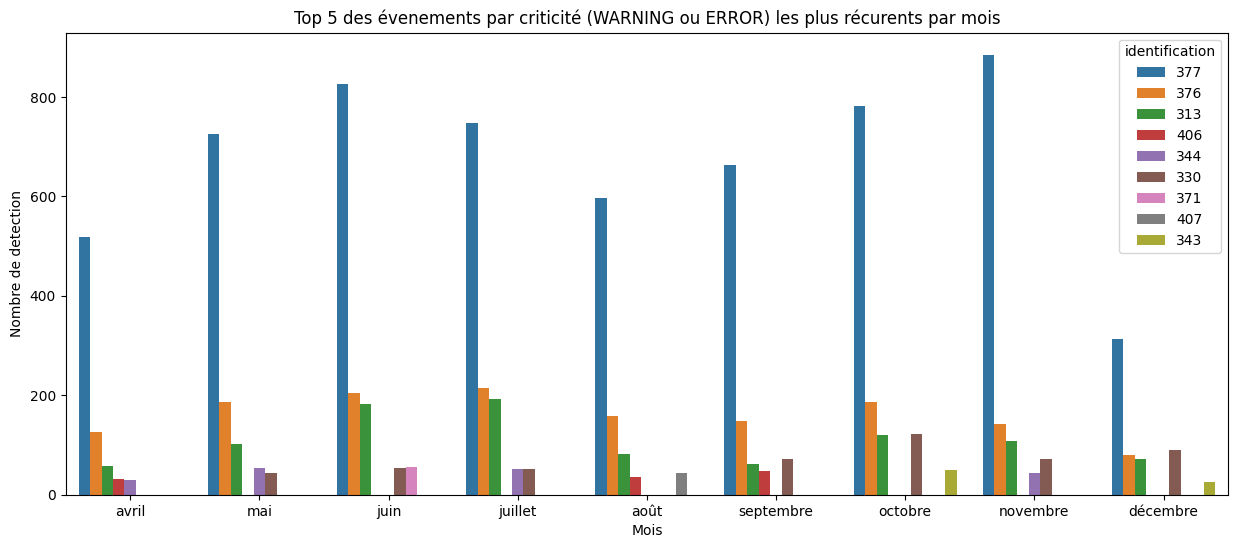

In [ ]:
# On filtrer pour n'inclure que les lignes avec 'ERR' ou 'WARNING'.
df_filtered = df_split[df_split['criticality'].isin(['ERR', 'WARNING'])]


# Rééchantillonnage par mois et comptage du nombre d'events_id pour chaque mois.
df_monthly_counts = df_filtered.resample('M')['identification'].value_counts().rename('count').reset_index()

# On groupe par la colonne "created_at" et on applique une fonction lambda à chaque groupe. 
# La fonction lambda prend les 5 premières lignes de chaque groupe sur la base de la colonne "count".
df_top5_monthly = df_monthly_counts.groupby('timestamp').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)

# On convertie les dates en Français
df_top5_monthly['Month'] = df_top5_monthly['timestamp'].apply(lambda x: format_date(x, 'MMMM', locale='fr_FR'))

# On affiche avec seaborn
plt.figure(figsize=(15, 6))
sns.barplot(x='Month', y='count', hue='identification', data=df_top5_monthly)
plt.title('Top 5 des évenements par criticité (WARNING ou ERROR) les plus récurents par mois')
plt.xlabel('Mois')
plt.ylabel('Nombre de detection')
plt.legend(title='identification')

plt.show()

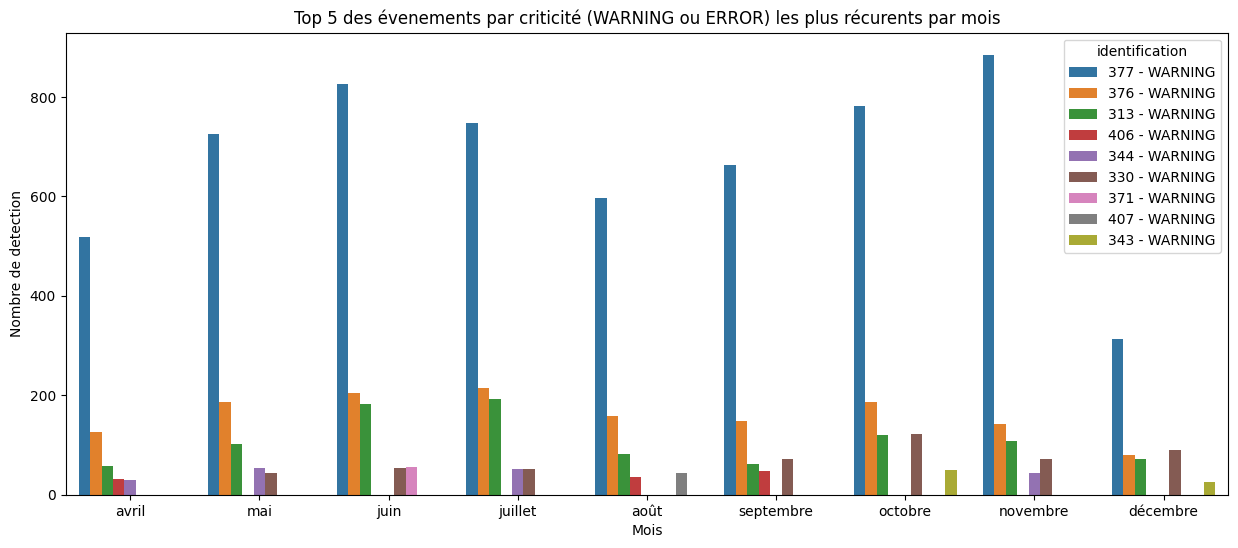

In [ ]:
df_filtered = df_split[df_split['criticality'].isin(['ERR', 'WARNING'])]

df_monthly_counts = df_filtered.resample('M')['identification'].value_counts().rename('count').reset_index()

df_top5_monthly = df_monthly_counts.groupby('timestamp').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)

# Merge the 'criticality' column from the original DataFrame into the df_top5_monthly DataFrame
df_top5_monthly = df_top5_monthly.merge(df_filtered[['identification', 'criticality']].drop_duplicates(), on='identification', how='left')

df_top5_monthly['Month'] = df_top5_monthly['timestamp'].apply(lambda x: format_date(x, 'MMMM', locale='fr_FR'))

# Create a new column that combines the values from the 'identification' and 'criticality' columns
df_top5_monthly['id_criticality'] = df_top5_monthly['identification'].astype(str) + ' - ' + df_top5_monthly['criticality']

# Update the hue parameter in the sns.barplot() function to use the new column
plt.figure(figsize=(15, 6))
sns.barplot(x='Month', y='count', hue='id_criticality', data=df_top5_monthly)
plt.title('Top 5 des évenements par criticité (WARNING ou ERROR) les plus récurents par mois')
plt.xlabel('Mois')
plt.ylabel('Nombre de detection')
plt.legend(title='identification')

plt.show()

In [ ]:
pd.set_option('display.max_rows', None)

# Group the DataFrame by 'identification' and calculate the number of unique values in the 'criticality' column
unique_criticality_counts = df_split.groupby('identification')['criticality'].nunique().reset_index()

# Rename the column for clarity
unique_criticality_counts.columns = ['identification', 'num_unique_criticality']

# Display the result
print(unique_criticality_counts)

   identification  num_unique_criticality
0            1000                       1
1            1001                       1
2            1002                       1
3            1003                       1
4            1004                       1
5               0                       2
6               2                       1
7             311                       2
8             313                       3
9             315                       2
10            320                       3
11            321                       1
12            322                       1
13            323                       1
14            324                       2
15            325                       3
16            326                       1
17            327                       1
18            329                       1
19            330                       3
20            331                       3
21            332                       2
22            333                 

In [ ]:
df_filtered.columns

Index(['source', 'message', 'criticality', 'identification', 'id',
       'varnishLevelsTargetvolume', 'varnishLevelsTotalvolume',
       'VarnishPrinter_3DVarnishCounter', 'iFoil_TotalPagesCounter'],
      dtype='object')

In [ ]:
# Group the dataframe by the 'source' and 'criticality' columns
grouped_df = df_split.groupby(['source', 'criticality'])

# Function to get unique values and their counts for a given series
def get_unique_counts(series):
    unique_counts = series.value_counts().to_dict()
    return unique_counts

# Iterate through the groups and compute the unique values and counts for the 'identification' column
result = {}
for (source, criticality), group in grouped_df:
    identification_counts = get_unique_counts(group['identification'])
    
    if source not in result:
        result[source] = {}
    
    result[source][criticality] = {
        'identification_counts': identification_counts
    }

# Pretty-print the result
pprint(result)

{'ICB n°1': {'ERROR': {'identification_counts': {1001: 28}}},
 'ICB n°2': {'ERROR': {'identification_counts': {1001: 112}}},
 'ICB n°4': {'ERROR': {'identification_counts': {1001: 20}}},
 'ICB n°5': {'ERROR': {'identification_counts': {1001: 104}}},
 'ICB n°6': {'ERROR': {'identification_counts': {1001: 9}}},
 'ICB n°7': {'ERROR': {'identification_counts': {1001: 2}}},
 'ICB n°8': {'ERROR': {'identification_counts': {1001: 19}}},
 'Kernel': {'ERROR': {'identification_counts': {1000: 1282}}},
 'PLC': {'ERROR': {'identification_counts': {'320': 56,
                                             '321': 34,
                                             '322': 2,
                                             '323': 9,
                                             '324': 12,
                                             '325': 271,
                                             '326': 2,
                                             '327': 1,
                                             '329': 3,
   

In [ ]:
df_test = df_split[df_split['source'].isin(['iFoil'])]

df_test['criticality'].value_counts()

df_filtered.head(15)

,source,message,criticality,identification,id,varnishLevelsTargetvolume,varnishLevelsTotalvolume,VarnishPrinter_3DVarnishCounter,iFoil_TotalPagesCounter
timestamp,,,,,,,,,
2022-04-15 06:07:37.675000+00:00,PLC,Chargeur: mode auto non activé,WARNING,377,4170172,36192.322612,100000,1792992,22881
2022-04-15 06:14:49.028000+00:00,PLC,Support lingette non installé,WARNING,315,4170409,36192.263131,100000,1792994,22883
2022-04-15 06:15:06.847000+00:00,PLC,Support lingette non installé,WARNING,315,4170426,36192.263131,100000,1792994,22883
2022-04-15 06:44:44.419000+00:00,PLC,Purge en cours,WARNING,406,4171448,36192.263131,100000,1792994,22883
2022-04-15 06:47:04.507000+00:00,PLC,Essuyage en cours,WARNING,407,4171522,36192.263131,100000,1792994,22883
2022-04-15 07:10:04.604000+00:00,PLC,Chargeur: mode auto non activé,WARNING,377,4172301,36191.951885,100000,1792998,22887
2022-04-15 07:19:22.497000+00:00,PLC,Chargeur: mode auto non activé,WARNING,377,4172644,36191.700548,100000,1793097,22986
2022-04-15 07:23:43.435000+00:00,PLC,Manque papier,WARNING,344,4172798,36174.990224,100000,1793133,23022
2022-04-15 07:57:56.286000+00:00,PLC,Chargeur: mode auto non activé,WARNING,377,4174193,36174.967539,100000,1793137,23026


In [ ]:
df_filtered['criticality'].unique()

array(['WARNING'], dtype=object)

In [ ]:
df_split['criticality'].unique()

array(['INFO', 'WARNING', 'ERROR'], dtype=object)

In [ ]:
# df_split.head(20).to_csv('output.csv', index=False)


In [ ]:
df_filtered.dtypes

source                              object
message                             object
criticality                         object
identification                      object
id                                   int64
varnishLevelsTargetvolume          float64
varnishLevelsTotalvolume             int64
VarnishPrinter_3DVarnishCounter      int64
iFoil_TotalPagesCounter              int64
dtype: object

In [ ]:
df_filtered.index

DatetimeIndex(['2022-04-15 06:07:37.675000+00:00',
               '2022-04-15 06:14:49.028000+00:00',
               '2022-04-15 06:15:06.847000+00:00',
               '2022-04-15 06:44:44.419000+00:00',
               '2022-04-15 06:47:04.507000+00:00',
               '2022-04-15 07:10:04.604000+00:00',
               '2022-04-15 07:19:22.497000+00:00',
               '2022-04-15 07:23:43.435000+00:00',
               '2022-04-15 07:57:56.286000+00:00',
               '2022-04-15 08:01:44.956000+00:00',
               ...
               '2022-12-12 07:49:27.170000+00:00',
               '2022-12-12 07:49:31.386000+00:00',
               '2022-12-12 07:54:05.025000+00:00',
               '2022-12-12 07:58:05.057000+00:00',
               '2022-12-12 07:58:49.305000+00:00',
               '2022-12-12 07:59:32.413000+00:00',
               '2022-12-12 08:02:01.188000+00:00',
               '2022-12-12 08:05:29.999000+00:00',
               '2022-12-12 08:12:38.491000+00:00',
            

<h1>Model</h1>

In [ ]:
df_filtered_copy = df_filtered.copy()

In [ ]:
le = LabelEncoder()
df_filtered_copy['criticality_encoded'] = le.fit_transform(df_filtered_copy['criticality'])

In [ ]:
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

# Run the ADF test on the 'criticality' column
adf_test(df_filtered_copy['criticality_encoded'])

ADF Statistic: nan
p-value: nan
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


p:\HubAcademy\AI\MGI\Prediction-Erreur-JetVarnish3D\venv\lib\site-packages\statsmodels\regression\linear_model.py:940: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
